In [16]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd, YearEnd
import datetime as dt
import matplotlib.pyplot as plt
import os
os.chdir("/Users/charlesrambo/Desktop/QIII/Quantitative Asset Management")

In [17]:
# Load stock information
stocks = pd.read_csv("stocks.csv")

In [18]:
# Record CRSP unkowns
unknowns = ["-66.0", "-77.0", "-88.0", "-99.0", "-99.99", "-999", "A", "B", "C", "D", "E", "S", "T", "P"]

# Create function to convert CRISP unkowns to np.nan
convert_unknows = lambda x: np.nan if x in unknowns else x

In [19]:
# Convert date column to date-time object
stocks['date'] = pd.to_datetime(stocks['date'], format = '%Y%m%d')

# Record observations where both returns and delisting returns are missing
stocks['flag'] = stocks['RET'].isna() & stocks['DLRET'].isna()

# Fill missing returns with 0
stocks['RET'] = stocks['RET'].apply(convert_unknows).astype(float).fillna(0)

# Fill missing delisting returns with 0
stocks['DLRET'] = stocks['DLRET'].apply(convert_unknows).astype(float).fillna(0)

# Compute cumulative returns from regular returns plus delisting returns
stocks['RET'] = (1 + stocks['RET']) * (1 + stocks['DLRET']) - 1

# Make 'stale' prices positive
stocks['PRC'] = stocks['PRC'].abs()

# Remove 0 priced observations
stocks = stocks.loc[stocks['PRC'] > 0]

# Remove non-positive shares outstanding
stocks = stocks.loc[stocks['SHROUT'] > 0]

# Only consider stocks listed on the big exchanges
stocks = stocks.loc[stocks['SHRCD'].isin([10, 11]) & stocks['EXCHCD'].isin([1, 2, 3, 31, 32, 33])]

# Drop unneeded columns
stocks.drop(['DLRET', 'SHRCD', 'EXCHCD', 'PERMCO'], axis = 1, inplace = True)

In [20]:
# Calculate market equity
stocks['ME'] = stocks['PRC'] * stocks['SHROUT']

# Short values for shift
stocks.sort_values(by = ['PERMNO', 'date'], inplace = True)

# Record the shifts which are valid
stocks['Isvalid'] = stocks['date'] + MonthEnd(0) == stocks['date'].shift(1) + dt.timedelta(days = 7) + MonthEnd(0)
stocks.loc[stocks['Isvalid'] == True, 'Isvalid'] = stocks.loc[stocks['Isvalid'] == True, 'PERMNO'] == stocks.loc[stocks['Isvalid'] == True, 'PERMNO'].shift(1)

# Shift market equity
stocks['ME_lag'] = stocks[['PERMNO', 'ME']].groupby('PERMNO')['ME'].shift(1)

# Replace the invalids with nan
stocks.loc[stocks['Isvalid'] == False, 'ME_lag'] = np.nan

# Fill missing values with 0
stocks['ME_lag'] = stocks['ME_lag'].fillna(0)

# Remove observations where both returns and delisting returns are missing
stocks = stocks.loc[~stocks['flag'], :]

# Drop unneeded columns
stocks.drop(['ME', 'Isvalid', 'flag'], axis = 1, inplace = True)

In [21]:
# Construct weighting
stocks['wt'] = stocks['ME_lag']
stocks['wt'] = stocks['wt']/stocks.groupby('date')['wt'].transform('sum')

# Calculate weighted returns
stocks['RET'] = stocks['RET'] * stocks['wt']

# Calculate market returns
mkt = stocks.groupby('date')['RET'].sum().reset_index()

# Shift date so that it's always the end of the month
mkt['date'] = mkt['date'] + MonthEnd(0)

mkt.head()

,date,RET
0,1972-12-31,0.000000
1,1973-01-31,0.000000
2,1973-02-28,-0.044228
3,1973-03-31,-0.008450
4,1973-04-30,-0.051531


In [22]:
stats = pd.DataFrame(index = mkt.columns[1:])

# Take a look at the mean
stats['mean'] = 12 * mkt.mean()

# Take a look at the sd
stats['sd'] = np.sqrt(12) * mkt.std()

# Take a look at the skew
stats['skew'] = 12**(3/2) * mkt.skew()

stats

,mean,sd,skew
RET,0.009449,0.04494,-0.543878


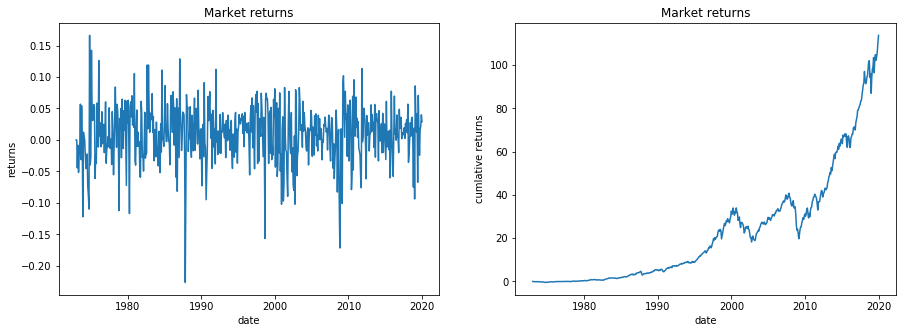

In [23]:
# Plot returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.plot(mkt['date'], mkt['RET'])
ax1.set_xlabel('date') 
ax1.set_ylabel('returns') 
ax1.set_title('Market returns') 

ax2.plot(mkt['date'], (1 + mkt['RET']).cumprod() - 1) 
ax2.set_xlabel('date') 
ax2.set_ylabel('cumlative returns') 
ax2.set_title('Market returns') 

plt.show()

In [24]:
# Load Daniel's momentum
FF3 = pd.read_csv('FF3.csv')

# Convert date to datetime object
FF3['date'] = pd.to_datetime(FF3['date'], format = '%Y%m')

# Move date to end of month
FF3['date'] = FF3['date'] + MonthEnd(0)

# Calculate Fama French market returns
FF3['mkt'] = FF3['Mkt-RF'] + FF3['RF']

# Convert to decimal
FF3['mkt'] = FF3['mkt']/100

FF3.head()

,date,Mkt-RF,SMB,HML,RF,mkt
0,1926-07-31,2.96,-2.30,-2.87,0.22,0.0318
1,1926-08-31,2.64,-1.40,4.19,0.25,0.0289
2,1926-09-30,0.36,-1.32,0.01,0.23,0.0059
3,1926-10-31,-3.24,0.04,0.51,0.32,-0.0292
4,1926-11-30,2.53,-0.20,-0.35,0.31,0.0284


In [25]:
# Merge with market construction
results = mkt.merge(FF3[['date', 'mkt']], on = 'date')

# See correlation
results['RET'].corr(results['mkt'])

0.9995941576059506